In [2]:
import os
import sys 
os.environ["SPARK_HOME"]="D:\\Code\\201511142\\spark-2.0.0-bin-hadoop2.6"
os.environ["PYLIB"]=os.path.join(os.environ["SPARK_HOME"],'python','lib')
sys.path.insert(0,os.path.join(os.environ["PYLIB"],'py4j-0.10.1-src.zip'))
sys.path.insert(0,os.path.join(os.environ["PYLIB"],'pyspark.zip'))

In [3]:
import pyspark
myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession.builder.master("local").appName("myApp").config(conf=myConf).config('spark.sql.warehouse.dir','file:///D:/Code/201511142/data').getOrCreate()

In [1]:
myList=list()
print myList

[]


In [28]:
myList=[('1','kim, js',170),
        ('1','lee, sm', 175),
        ('2','lim, yg',180),
        ('2','lee',170)]
myDf=spark.createDataFrame(myList)
myDf.printSchema()
print myDf.take(1) #첫번째 줄 출력


root
 |-- _1: string (nullable = true)
 |-- _2: string (nullable = true)
 |-- _3: long (nullable = true)

[Row(_1=u'1', _2=u'kim, js', _3=170)]


In [7]:
print spark.createDataFrame(myList, ['year','name','height']).take(1)

[Row(year=u'1', name=u'kim, js', height=170)]


In [9]:
names = ["kim","lee","lee","lim"]
items = ["espresso","latte","americano","affocato","long black","macciato"]
df = spark.createDataFrame([(names[i%4], items[i%5]) for i in range(100)],\
                           ["name","item"])#random 으로 데이터 만듦
df.show(10)

+----+----------+
|name|      item|
+----+----------+
| kim|  espresso|
| lee|     latte|
| lee| americano|
| lim|  affocato|
| kim|long black|
| lee|  espresso|
| lee|     latte|
| lim| americano|
| kim|  affocato|
| lee|long black|
+----+----------+
only showing top 10 rows



In [30]:
from pyspark.sql import Row
Person = Row('year','name', 'height')
row1=Person('1','kim, js',170)
print "row1: ",row1.year, row1.name

row1:  1 kim, js


In [31]:
myRows = [row1,
          Person('1','lee, sm', 175),
          Person('2','lim, yg',180),
          Person('2','lee',170)]

myDf=spark.createDataFrame(myRows)
print myDf.printSchema()
myDf.show()

root
 |-- year: string (nullable = true)
 |-- name: string (nullable = true)
 |-- height: long (nullable = true)

None
+----+-------+------+
|year|   name|height|
+----+-------+------+
|   1|kim, js|   170|
|   1|lee, sm|   175|
|   2|lim, yg|   180|
|   2|    lee|   170|
+----+-------+------+



In [32]:
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import StringType, IntegerType
mySchema=StructType([
    StructField("year", StringType(), True),
    StructField("name", StringType(), True),
    StructField("height", IntegerType(), True)
])
myDf=spark.createDataFrame(myRows, mySchema)
myDf.printSchema()
myDf.take(1)

root
 |-- year: string (nullable = true)
 |-- name: string (nullable = true)
 |-- height: integer (nullable = true)



[Row(year=u'1', name=u'kim, js', height=170)]

In [35]:
from pyspark.sql import Row

myList=[('1','kim, js',170),('1','lee, sm', 175),('2','lim, yg',180),('2','lee',170)]
myRdd = spark.sparkContext.parallelize(myList)

In [36]:
rddDf=myRdd.toDF()
rddDf.printSchema()

root
 |-- _1: string (nullable = true)
 |-- _2: string (nullable = true)
 |-- _3: long (nullable = true)



In [37]:
rddDf=spark.createDataFrame(myRdd)
rddDf.printSchema()

root
 |-- _1: string (nullable = true)
 |-- _2: string (nullable = true)
 |-- _3: long (nullable = true)



In [38]:
rddDf.where(rddDf._3 < 175)\
    .select([rddDf._1, rddDf._2]).show()
rddDf.groupby(rddDf._1).max().show()  #필터역할

+---+-------+
| _1|     _2|
+---+-------+
|  1|kim, js|
|  2|    lee|
+---+-------+

+---+-------+
| _1|max(_3)|
+---+-------+
|  1|    175|
|  2|    180|
+---+-------+



In [39]:
_myRdd=myRdd.map(lambda x:Row(year=int(x[0]),name=x[1],height=int(x[2])))
_myDf=spark.createDataFrame(_myRdd)
_myDf.printSchema()
_myDf.take(1)

root
 |-- height: long (nullable = true)
 |-- name: string (nullable = true)
 |-- year: long (nullable = true)



[Row(height=170, name=u'kim, js', year=1)]

In [40]:
from pyspark.sql import Row
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import StringType, IntegerType, TimestampType
r1=Row(name="js1",age=10)
r2=Row(name="js2",age=20)
_myRdd=spark.sparkContext.parallelize([r1,r2])
_myRdd.collect()

[Row(age=10, name='js1'), Row(age=20, name='js2')]

In [41]:
schema=StructType([
    StructField("age", IntegerType(), True),
    StructField("name", StringType(), True),
    #StructField("created", TimestampType(), True)
])
_myDf=spark.createDataFrame(_myRdd,schema)
_myDf.printSchema()
_myDf.show()

root
 |-- age: integer (nullable = true)
 |-- name: string (nullable = true)

+---+----+
|age|name|
+---+----+
| 10| js1|
| 20| js2|
+---+----+



In [42]:
myDf.toPandas()

,year,name,height
0,1,"kim, js",170
1,1,"lee, sm",175
2,2,"lim, yg",180
3,2,lee,170


In [43]:
from pyspark.sql import Row
cfile= os.path.join(os.environ["SPARK_HOME"],\
           "examples/src/main/resources/people.txt")
lines = spark.sparkContext.textFile(cfile)
parts = lines.map(lambda l: l.split(","))
people = parts.map(lambda p: Row(name=p[0], age=int(p[1].strip())))

_myDf = spark.createDataFrame(people)
_myDf.printSchema()
_myDf.collect()

root
 |-- age: long (nullable = true)
 |-- name: string (nullable = true)



[Row(age=29, name=u'Michael'),
 Row(age=30, name=u'Andy'),
 Row(age=19, name=u'Justin')]

In [44]:
%%writefile data/ds_spark.csv
1,2,3,4
11,22,33,44
111,222,333,444

Overwriting data/ds_spark.csv


In [45]:
df = spark.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('data/ds_spark.csv')
df.show()

+---+---+---+---+
|  1|  2|  3|  4|
+---+---+---+---+
| 11| 22| 33| 44|
|111|222|333|444|
+---+---+---+---+



In [11]:
%%writefile D:\Code\201511142\spark-2.0.0-bin-hadoop2.6\conf\spark-defaults.conf
#
# Licensed to the Apache Software Foundation (ASF) under one or more
# contributor license agreements.  See the NOTICE file distributed with
# this work for additional information regarding copyright ownership.
# The ASF licenses this file to You under the Apache License, Version 2.0
# (the "License"); you may not use this file except in compliance with
# the License.  You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

# Default system properties included when running spark-submit.
# This is useful for setting default environmental settings.

# Example:
# spark.master                     spark://master:7077
# spark.eventLog.enabled           true
# spark.eventLog.dir               hdfs://namenode:8021/directory
# spark.serializer                 org.apache.spark.serializer.KryoSerializer
# spark.driver.memory              5g
# spark.executor.extraJavaOptions  -XX:+PrintGCDetails -Dkey=value -Dnumbers="one two three"
spark.jars.package= org.mongodb.spark:mongo-spark-connector_2.10:2.0.0, com.databricks:spark-csv_2.11:1.5.0


Overwriting D:\Code\201511142\spark-2.0.0-bin-hadoop2.6\conf\spark-defaults.conf


In [14]:
import numpy as np
np.array([float(x) for x in '1.658985	4.285136'.split('\t')])

array([ 1.658985,  4.285136])

In [15]:
import numpy as np
np.array([float(x) for x in '1.658985 4.285136'.split(' ')])

array([ 1.658985,  4.285136])

In [16]:
%%writefile data/ds_spark_heightweight.txt
1	65.78	112.99
2	71.52	136.49
3	69.40	153.03
4	68.22	142.34
5	67.79	144.30
6	68.70	123.30
7	69.80	141.49
8	70.01	136.46
9	67.90	112.37
10	66.78	120.67
11	66.49	127.45
12	67.62	114.14
13	68.30	125.61
14	67.12	122.46
15	68.28	116.09
16	71.09	140.00
17	66.46	129.50
18	68.65	142.97
19	71.23	137.90
20	67.13	124.04
21	67.83	141.28
22	68.88	143.54
23	63.48	97.90
24	68.42	129.50
25	67.63	141.85
26	67.21	129.72
27	70.84	142.42
28	67.49	131.55
29	66.53	108.33
30	65.44	113.89
31	69.52	103.30
32	65.81	120.75
33	67.82	125.79
34	70.60	136.22
35	71.80	140.10
36	69.21	128.75
37	66.80	141.80
38	67.66	121.23
39	67.81	131.35
40	64.05	106.71
41	68.57	124.36
42	65.18	124.86
43	69.66	139.67
44	67.97	137.37
45	65.98	106.45
46	68.67	128.76
47	66.88	145.68
48	67.70	116.82
49	69.82	143.62
50	69.09	134.93 

Writing data/ds_spark_heightweight.txt


In [18]:
from pyspark.sql.types import *
rdd=spark.sparkContext.textFile(os.path.join('data','ds_spark_heightweight.txt'))
tRdd=rdd.map(lambda x:x.split('\t'))
tDf=spark.createDataFrame(tRdd)

In [20]:
tDf.printSchema()

root
 |-- _1: string (nullable = true)
 |-- _2: string (nullable = true)
 |-- _3: string (nullable = true)



In [21]:
tDf=tDf.withColumn("id",tDf['_1'].cast("integer")).drop('_1')
tDf=tDf.withColumn("height",tDf['_2'].cast("double")).drop('_2')
tDf=tDf.withColumn("weight",tDf['_3'].cast("double")).drop('_3')

In [22]:
import numpy as np
_weightRdd=tDf.rdd.map(lambda fields:fields[1]).collect()
_heightRdd=tDf.rdd.map(lambda fields:fields[2]).collect()
print np.array(_weightRdd)[:5]
print np.array(_heightRdd)[:5]

[ 65.78  71.52  69.4   68.22  67.79]
[ 112.99  136.49  153.03  142.34  144.3 ]


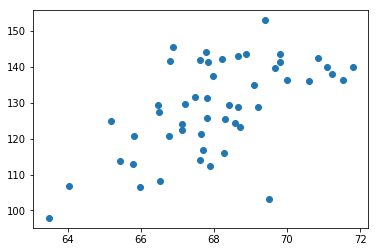

In [23]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.plot(np.array(_weightRdd), np.array(_heightRdd),'o')
plt.show()

In [24]:
jfile= os.path.join(os.environ["SPARK_HOME"],\
           "examples/src/main/resources/people.json")

_myDf= spark.read.json(jfile)
_myDf.filter(_myDf['age'] > 21).show()


+---+----+
|age|name|
+---+----+
| 30|Andy|
+---+----+



In [25]:
import requests
r=requests.get("https://raw.githubusercontent.com/jokecamp/FootballData/master/World%20Cups/all-world-cup-players.json")
wc=r.json()  #dataframe으로 만들기

In [46]:
from pyspark.sql import Row
cfile= os.path.join(os.environ["SPARK_HOME"],\
           "examples/src/main/resources/people.txt")
lines = spark.sparkContext.textFile(cfile)
parts = lines.map(lambda l: l.split(","))
people = parts.map(lambda p: Row(name=p[0], age=int(p[1].strip())))

_myDf = spark.createDataFrame(people)
_myDf.printSchema()
_myDf.collect()

root
 |-- age: long (nullable = true)
 |-- name: string (nullable = true)



[Row(age=29, name=u'Michael'),
 Row(age=30, name=u'Andy'),
 Row(age=19, name=u'Justin')]

In [5]:
%%writefile data/ds_spark.csv
1,2,3,4
11,22,33,44
111,222,333,444

Overwriting data/ds_spark.csv


In [6]:
df = spark.read.format('com.databricks.spark.csv')\
    .options(header='true', inferschema='true').load('data/ds_spark.csv')
df.show()

+---+---+---+---+
|  1|  2|  3|  4|
+---+---+---+---+
| 11| 22| 33| 44|
|111|222|333|444|
+---+---+---+---+



In [7]:
import requests
r=requests.get("https://raw.githubusercontent.com/jokecamp/FootballData/master/World%20Cups/all-world-cup-players.json")
wc=r.json()

In [8]:
print type(wc), type(wc[0])

<type 'list'> <type 'dict'>


In [9]:
wcDF=spark.createDataFrame(wc)
wcDF.printSchema()
wcDF.take(1)

D:\Code\201511142\spark-2.0.0-bin-hadoop2.6\python\lib\pyspark.zip\pyspark\sql\session.py:316: UserWarning: inferring schema from dict is deprecated,please use pyspark.sql.Row instead
  warnings.warn("inferring schema from dict is deprecated,"


root
 |-- Club: string (nullable = true)
 |-- ClubCountry: string (nullable = true)
 |-- Competition: string (nullable = true)
 |-- DateOfBirth: string (nullable = true)
 |-- FullName: string (nullable = true)
 |-- IsCaptain: boolean (nullable = true)
 |-- Number: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- Team: string (nullable = true)
 |-- Year: long (nullable = true)



[Row(Club=u'Club Atl\xc3\xa9tico Talleres de Remedios de Escalada', ClubCountry=u'Argentina', Competition=u'World Cup', DateOfBirth=u'1905-5-5', FullName=u'\xc3ngel Bossio', IsCaptain=False, Number=u'', Position=u'GK', Team=u'Argentina', Year=1930)]

In [60]:
wcRdd=spark.sparkContext.parallelize(wc)
wcRdd.take(1)

[{u'Club': u'Club Atl\xc3\xa9tico Talleres de Remedios de Escalada',
  u'ClubCountry': u'Argentina',
  u'Competition': u'World Cup',
  u'DateOfBirth': u'1905-5-5',
  u'FullName': u'\xc3ngel Bossio',
  u'IsCaptain': False,
  u'Number': u'',
  u'Position': u'GK',
  u'Team': u'Argentina',
  u'Year': 1930}]

In [61]:
from pyspark.sql.types import *
wcSchema=StructType([
    StructField("Club", StringType(), True),
    StructField("ClubCountry", StringType(), True),
    StructField("Competition", StringType(), True),
    StructField("DateOfBirth", DateType(), True),
    StructField("FullName", StringType(), True),
    StructField("IsCaptain", BooleanType(), True),
    StructField("Number", IntegerType(), True),
    StructField("Position", StringType(), True),
    StructField("Team", StringType(), True),
    StructField("Year", IntegerType(), True)
])

wcDF=spark.createDataFrame(wcRdd)
wcDF.printSchema()
wcDF.take(1)

D:\Code\201511142\spark-2.0.0-bin-hadoop2.6\python\lib\pyspark.zip\pyspark\sql\session.py:336: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


root
 |-- Club: string (nullable = true)
 |-- ClubCountry: string (nullable = true)
 |-- Competition: string (nullable = true)
 |-- DateOfBirth: string (nullable = true)
 |-- FullName: string (nullable = true)
 |-- IsCaptain: boolean (nullable = true)
 |-- Number: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- Team: string (nullable = true)
 |-- Year: long (nullable = true)



[Row(Club=u'Club Atl\xc3\xa9tico Talleres de Remedios de Escalada', ClubCountry=u'Argentina', Competition=u'World Cup', DateOfBirth=u'1905-5-5', FullName=u'\xc3ngel Bossio', IsCaptain=False, Number=u'', Position=u'GK', Team=u'Argentina', Year=1930)]

In [62]:
from datetime import datetime
print datetime.strptime("11/25/1991", '%m/%d/%Y')

1991-11-25 00:00:00


In [63]:
wcDF=wcDF.withColumn('DoB', wcDF['DateOfBirth'].cast(DateType()))
wcDF=wcDF.withColumn('NumberInt', wcDF['Number'].cast("integer"))
wcDF.printSchema()
wcDF.take(1)

root
 |-- Club: string (nullable = true)
 |-- ClubCountry: string (nullable = true)
 |-- Competition: string (nullable = true)
 |-- DateOfBirth: string (nullable = true)
 |-- FullName: string (nullable = true)
 |-- IsCaptain: boolean (nullable = true)
 |-- Number: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- Team: string (nullable = true)
 |-- Year: long (nullable = true)
 |-- DoB: date (nullable = true)
 |-- NumberInt: integer (nullable = true)



[Row(Club=u'Club Atl\xc3\xa9tico Talleres de Remedios de Escalada', ClubCountry=u'Argentina', Competition=u'World Cup', DateOfBirth=u'1905-5-5', FullName=u'\xc3ngel Bossio', IsCaptain=False, Number=u'', Position=u'GK', Team=u'Argentina', Year=1930, DoB=datetime.date(1905, 5, 5), NumberInt=None)]

In [49]:
myDf.printSchema()
myDf.show()

root
 |-- year: string (nullable = true)
 |-- name: string (nullable = true)
 |-- height: integer (nullable = true)

+----+-------+------+
|year|   name|height|
+----+-------+------+
|   1|kim, js|   170|
|   1|lee, sm|   175|
|   2|lim, yg|   180|
|   2|    lee|   170|
+----+-------+------+



In [50]:
_name=myDf.select('name')
_name.rdd.collect()

[Row(name=u'kim, js'),
 Row(name=u'lee, sm'),
 Row(name=u'lim, yg'),
 Row(name=u'lee')]

In [16]:
wcDF=wcDF.withColumnRenamed('ClubCountry','ClubNation')
wcDF.printSchema()

root
 |-- Club: string (nullable = true)
 |-- ClubNation: string (nullable = true)
 |-- Competition: string (nullable = true)
 |-- DateOfBirth: string (nullable = true)
 |-- FullName: string (nullable = true)
 |-- IsCaptain: boolean (nullable = true)
 |-- Number: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- Team: string (nullable = true)
 |-- Year: long (nullable = true)



In [19]:
myList=[('1','kim, js',170),
        ('1','lee, sm', 175),
        ('2','lim, yg',180),
        ('2','lee',170)]
myDf=spark.createDataFrame(myList)
myDf.show()

+---+-------+---+
| _1|     _2| _3|
+---+-------+---+
|  1|kim, js|170|
|  1|lee, sm|175|
|  2|lim, yg|180|
|  2|    lee|170|
+---+-------+---+



In [53]:
myDf.where(myDf['height'] < 175)\
    .select(myDf['name'], myDf['height']).show()
myDf.groupby(myDf['year']).max().show()

+-------+------+
|   name|height|
+-------+------+
|kim, js|   170|
|    lee|   170|
+-------+------+

+----+-----------+------------+----------+
|year|max(height)|max(heightD)|max(yearI)|
+----+-----------+------------+----------+
|   1|        175|       175.0|         1|
|   2|        180|       180.0|         2|
+----+-----------+------------+----------+



In [23]:
wcDF.printSchema()

root
 |-- Club: string (nullable = true)
 |-- ClubNation: string (nullable = true)
 |-- Competition: string (nullable = true)
 |-- DateOfBirth: string (nullable = true)
 |-- FullName: string (nullable = true)
 |-- IsCaptain: boolean (nullable = true)
 |-- Number: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- Team: string (nullable = true)
 |-- Year: long (nullable = true)



In [65]:
wcDF.createReplaceTempView("wc")#data tabl의 이름을 만듦
spark.sql("select Club,Team,Year from wc").show(1) #가상 테이블 명과 동일하게

AttributeError: 'DataFrame' object has no attribute 'createReplaceTempView'

In [25]:
spark.catalog.listTables()

[]

In [26]:
wcDF.createOrReplaceTempView("wc")#있으면 기존것 씀
wcPlayers=spark.sql("select FullName,Club,Team,Year from wc")

In [27]:
namesRdd=wcPlayers.rdd.map(lambda x: "Full name: "+x[0])
for e in namesRdd.take(5):
    print e

Full name: Ãngel Bossio
Full name: Juan Botasso
Full name: Roberto Cherro
Full name: Alberto Chividini
Full name: 


In [51]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

toDoublefunc = udf(lambda x: float(x),DoubleType())
myDf = myDf.withColumn("heightD",toDoublefunc(myDf.height))

In [52]:
from pyspark.sql.functions import udf, struct
from pyspark.sql.types import IntegerType
toint=udf(lambda x:int(x),IntegerType())
myDf=myDf.withColumn("yearI",toint(myDf['year']))

myDf.printSchema()
myDf.show()

root
 |-- year: string (nullable = true)
 |-- name: string (nullable = true)
 |-- height: integer (nullable = true)
 |-- heightD: double (nullable = true)
 |-- yearI: integer (nullable = true)

+----+-------+------+-------+-----+
|year|   name|height|heightD|yearI|
+----+-------+------+-------+-----+
|   1|kim, js|   170|  170.0|    1|
|   1|lee, sm|   175|  175.0|    1|
|   2|lim, yg|   180|  180.0|    2|
|   2|    lee|   170|  170.0|    2|
+----+-------+------+-------+-----+



In [67]:
import os
import urllib
_url = 'http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz'
_fname = os.path.join(os.getcwd(),'data','kddcup.data_10_percent.gz')
if(not os.path.exists(_fname)):
    print "%s data does not exist! retrieving.." % _fname
    _f=urllib.urlretrieve(_url,_fname)

D:\Code\201511142\data\kddcup.data_10_percent.gz data does not exist! retrieving..


In [68]:
_rdd=spark.sparkContext.textFile(_fname)

In [69]:
_rdd.count()

494021

In [70]:
_rdd.take(3)

[u'0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,9,9,1.00,0.00,0.11,0.00,0.00,0.00,0.00,0.00,normal.',
 u'0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,19,19,1.00,0.00,0.05,0.00,0.00,0.00,0.00,0.00,normal.',
 u'0,tcp,http,SF,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,29,29,1.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,normal.']

In [71]:
_normal=_rdd.filter(lambda x:'normal.' in x)
print _normal.count()

97278


In [73]:
_csvRdd=_rdd.map(lambda x: x.split(','))
print _csvRdd.take(1)

[[u'0', u'tcp', u'http', u'SF', u'181', u'5450', u'0', u'0', u'0', u'0', u'0', u'1', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'8', u'8', u'0.00', u'0.00', u'0.00', u'0.00', u'1.00', u'0.00', u'0.00', u'9', u'9', u'1.00', u'0.00', u'0.11', u'0.00', u'0.00', u'0.00', u'0.00', u'0.00', u'normal.']]


In [74]:
_kv=_csvRdd.map(lambda x:(x[41],1))
_attack=_kv.reduceByKey(lambda x,y:x+y) #groupByKey와 동일-전체를 셈

In [75]:
_attack.collect()

[(u'guess_passwd.', 53),
 (u'nmap.', 231),
 (u'warezmaster.', 20),
 (u'rootkit.', 10),
 (u'warezclient.', 1020),
 (u'smurf.', 280790),
 (u'pod.', 264),
 (u'neptune.', 107201),
 (u'normal.', 97278),
 (u'spy.', 2),
 (u'ftp_write.', 8),
 (u'phf.', 4),
 (u'portsweep.', 1040),
 (u'teardrop.', 979),
 (u'buffer_overflow.', 30),
 (u'land.', 21),
 (u'imap.', 12),
 (u'loadmodule.', 9),
 (u'perl.', 3),
 (u'multihop.', 7),
 (u'back.', 2203),
 (u'ipsweep.', 1247),
 (u'satan.', 1589)]

In [77]:
_normalRdd=_csvRdd.filter(lambda x:x[41]=="normal.")
_attackRdd=_csvRdd.filter(lambda x:x[41]!="normal.")
print _normalRdd.count()
print _attackRdd.count()

97278
396743


In [78]:
from pyspark.sql import Row

_csv = _rdd.map(lambda l: l.split(","))
_csvRdd = _csv.map(lambda p: 
    Row(
        duration=int(p[0]), 
        protocol=p[1],
        service=p[2],
        flag=p[3],
        src_bytes=int(p[4]),
        dst_bytes=int(p[5])
    )
)

In [79]:
type(_csvRdd)

pyspark.rdd.PipelinedRDD